### Imports

In [49]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime
import heapq
import xgboost as xgb
import h5py
from tqdm import tqdm_notebook as tqdm

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize
from keras.models import model_from_json
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means

from cyclicLR_callback import CyclicLR

random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

In [2]:
import keras
keras.__version__

'2.1.2'

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [3]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [4]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


### Load Data

In [5]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


### Missing values

In [7]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


### Transform for NN

In [8]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

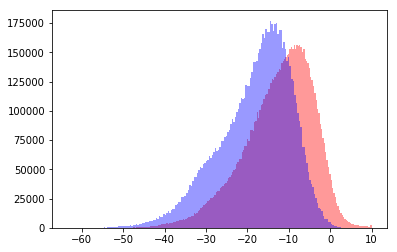

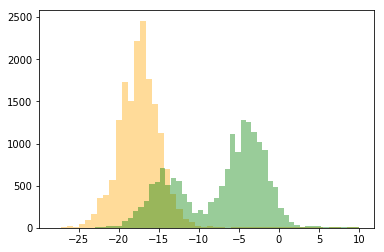

In [9]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

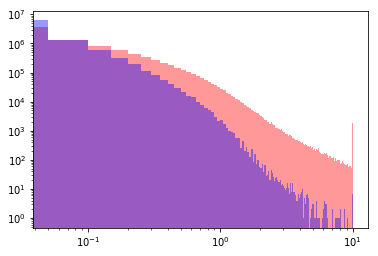

In [10]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

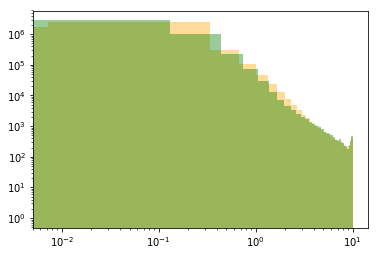

In [11]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

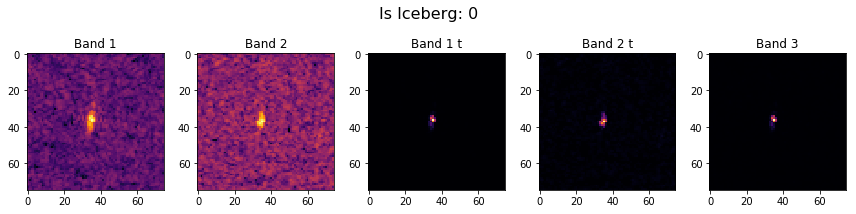

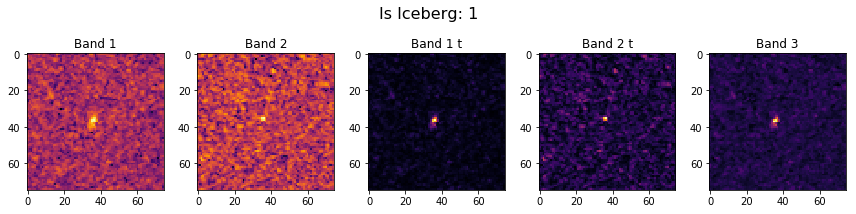

In [12]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [13]:
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index

In [14]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


### Split into train test and validation sets

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


### Data augmentation

In [16]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)


(1122, 75, 75, 4)


### Learning rate scheduler and callback definition

In [17]:
# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001, drop=0.66, patience=5):
        self.initial_lrate=initial_lrate
        self.drop = drop
        self.patience = patience

    def step_decay(self,epoch):
        initial_lrate = self.initial_lrate
        drop = self.drop
        patience = self.patience
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

### Denoising

In [18]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [19]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [20]:
#X_denoised = apply_over_axis(denoising, X)

In [21]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Denoised")
#ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Denoised - band 2")
#ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### NN denoising

In [22]:
#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [23]:
m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])

In [24]:
model_denoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         (None, 75, 75, 4)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 4)         16        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 8)         296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 8)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 77, 77, 8)         0         
__________

In [25]:
#model training
#lScheduler_denoising = LScheduler(initial_lrate=0.1, drop=0.66, patience=3)
#lrScheduler_denoising = LearningRateScheduler(lScheduler_denoising.step_decay)
lrScheduler_denoising = CyclicLR(base_lr=1e-8, max_lr=0.006,
                                 step_size=400, mode='triangular2', gamma=0.99994)
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
                    steps_per_epoch=len(X)/8,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
                    validation_steps=len(X)/8,
                    #validation_data=[X_val,y_val],
                    epochs=12,
                    callbacks = [lrScheduler_denoising, 
                                 TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

HBox(children=(IntProgress(value=0, description='Training', max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=200), HTML(value='')))


Model training time: 1 minutes 11.3 seconds


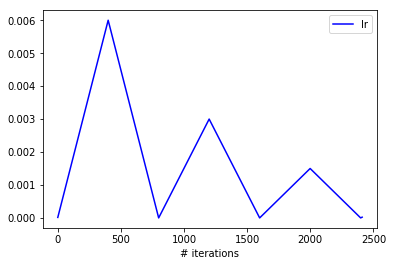

In [26]:
h = lrScheduler_denoising.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

In [27]:
# serialize model to JSON
model_json = model_denoise.to_json()
with open("models/model_denoise.json", "w") as json_file:
    json_file.write(model_json)

In [28]:
# serialize weights to HDF5
model_weights = model_denoise.get_weights()
with open('models/model_denoise_weights.pickle', 'wb') as handle:
    pickle.dump(model_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
# load json and create model
with open("models/model_denoise.json", "r") as json_file:
    loaded_model_json = json_file.read()
model_denoise = model_from_json(loaded_model_json)
# load weights into new model
with open('models/model_denoise_weights.pickle', 'rb') as handle:
    model_weights = pickle.load(handle)
model_denoise.set_weights(model_weights)
print("Loaded model from disk")

Loaded model from disk


In [30]:
X_nn_denoised = model_denoise.predict(X, verbose=1)

1604/1604 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 1ms/step


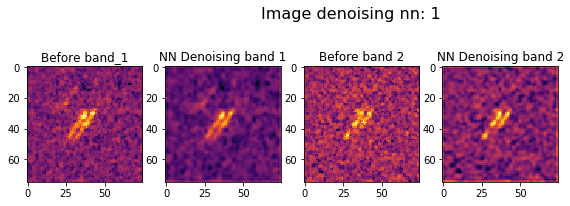

In [31]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("NN Denoising band 1")
ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("NN Denoising band 2")
ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

### Keras model

In [32]:
model_code="CNN_2018_01_21_v01"
model_comment="2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0"

In [33]:
%%writefile current_model.py

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
x3 = model_denoise(aux_input_nn)
x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn')

x = Concatenate(axis=3)([x1,x2,x3])
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
#x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        aux_input_nn, 
                        angle_input], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [45]:
%run -i current_model.py

In [35]:
class ModelHistory(Callback):
    def __init__(self, listSize=10):
        self.listSize = listSize
        self.models = []

    def on_epoch_end(self, epoch, logs={}):
        lastLoss = logs.get('val_loss')
        rank = 1 - lastLoss
        if len(self.models) > 0:
            if rank > self.models[0][0]: # new model is better than the worst in the heap
                if len(self.models) >= self.listSize: #if the model heap is already full
                    heapq.heappushpop(self.models, (rank, lastLoss, self.model.get_weights()))
                else:
                    heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))
        else:
            heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))

def get_callbacks(filepath, save_to_disc = True, lScheduler = None,
                  patience=10, step_decay=LScheduler().step_decay, modelHistoryCallback=None):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    if lScheduler is None:
        lrScheduler = LearningRateScheduler(step_decay)
    else:
        lrScheduler = lScheduler
    tqdmCallback =  TQDMNotebookCallback(leave_inner=True, leave_outer=True)
    if (save_to_disc):
        return [msave, lrScheduler, modelHistoryCallback, tqdmCallback]
    else:
        return [lrScheduler, modelHistoryCallback, tqdmCallback]

In [36]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aux_input_nn (InputLayer)       (None, 75, 75, 4)    0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
Model_nn_denoising (Model)      (None, 75, 75, 4)    1252        aux_input_nn[0][0]               
__________________________________________________________________________________________________
batch_norm

Non-trainable params: 2,748
__________________________________________________________________________________________________


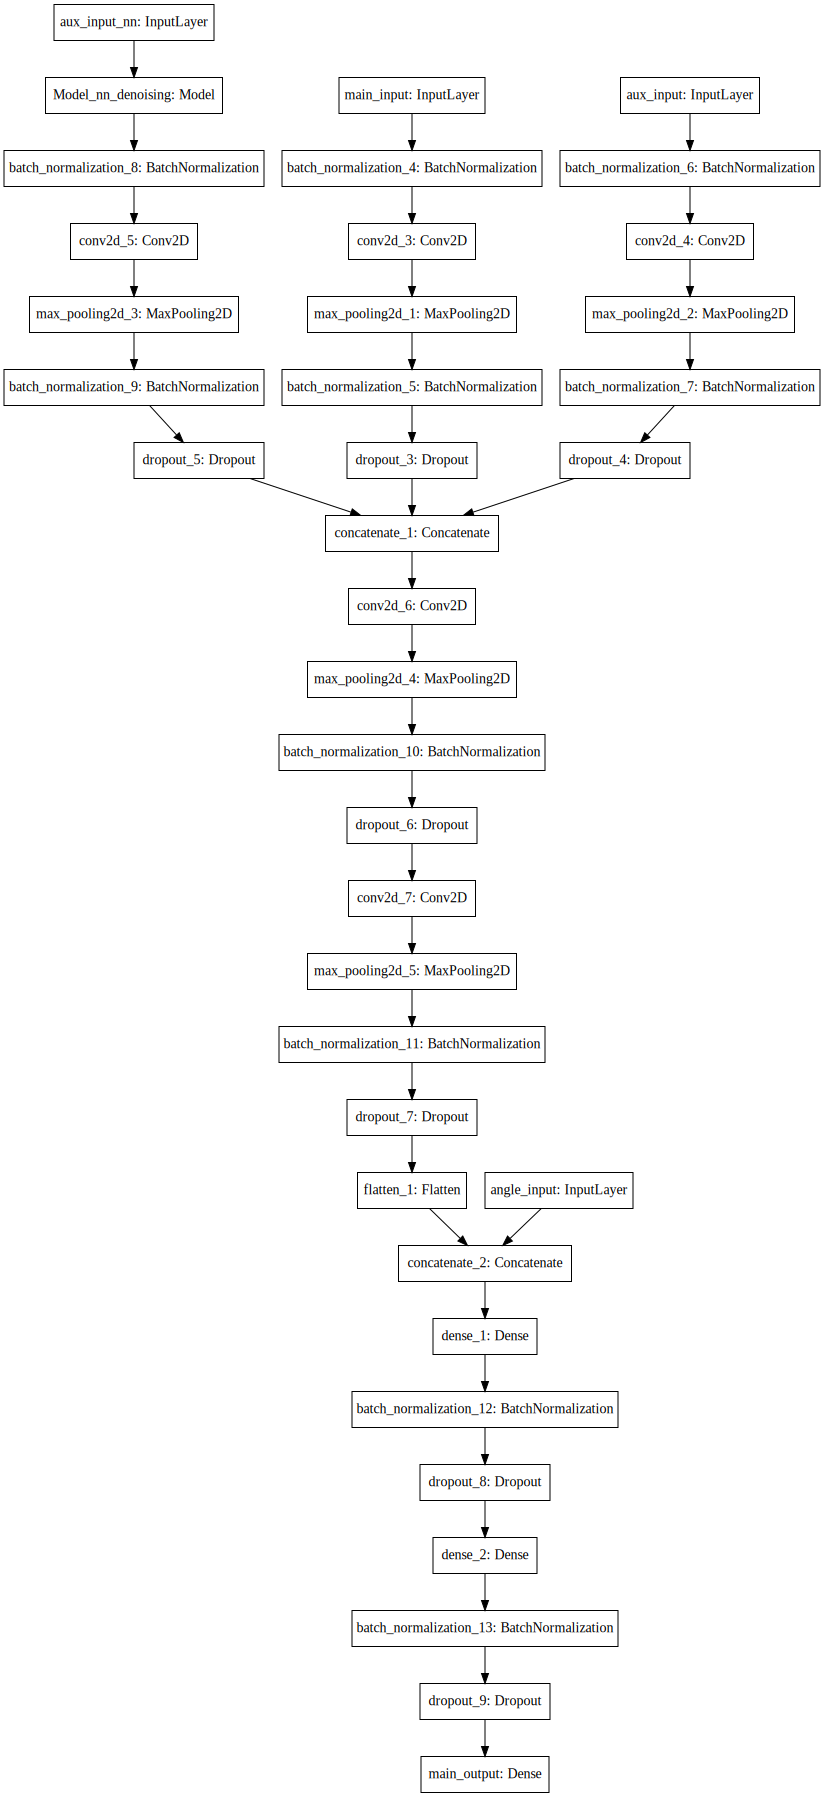

In [37]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [50]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
#lScheduler = LScheduler(initial_lrate=0.001, drop=0.66, patience=7)
modelEnsemble = ModelHistory(listSize=21)
lScheduler = CyclicLR(base_lr=1e-9, max_lr=0.001,
                                 step_size=300, mode='traingular3', beta=0.66)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble)

In [51]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=16),
                    steps_per_epoch=len(X_train_sample)/16,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/24,
                    #validation_data=[X_val,y_val],
                    epochs=70, callbacks=callbacks,
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

HBox(children=(IntProgress(value=0, description='Training', max=70), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=70), HTML(value='')))

AttributeError: 'CyclicLR' object has no attribute 'scale_mode'

In [ ]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

In [ ]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [ ]:
model_f.set_weights(modelEnsemble.models[len(modelEnsemble.models)-1][2])

### Additional training epochs with SGD - warm start

In [ ]:
#addtional training epochs - warm start
#lScheduler = LScheduler(initial_lrate=0.000001, drop=0.66, patience=3)
modelEnsemble2 = ModelHistory(listSize=5)
lScheduler = CyclicLR(base_lr=1e-9, max_lr=1e-5,
                                 step_size=80, mode='triangular2', gamma=0.9994)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble2)
model_f.compile(optimizer=SGD(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24, shuffle=False),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/24,
                    #validation_data=[X_val,y_val],
                    epochs=15, callbacks=callbacks,
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

In [ ]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

In [ ]:
for key in H.history:
    H.history[key].extend(H2.history[key])

In [ ]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [ ]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model_f.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# load model from JSON - don't care about the weights rith now, they are saved separately
with open("models/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_f = model_from_json(loaded_model_json)

In [ ]:
#model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
#model_f.save('models/last_model.hdf5') //crashes python kernel with Keras version 2.1.2
#model_f = load_model(model_object_path)

### Saving model history

In [ ]:
argmin = np.array(H.history["loss"]).argmin()
argmin

In [ ]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
#with open('current_model.py','r') as model_python_code_file:
#    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
#                                    "val_loss [min]":[H.history['val_loss'][argmin]],
#                                    "epoch [val_loss [min]]":argmin,
#                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
#                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
#                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
#                                    
#                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
#                                    "epoch [val_acc [max]]":argmax_acc,
#                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
#                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
#                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
#                                    
#                                    "model_path":[model_object_path],
#                                    "model_weights_path":[model_best_weights_path],
#                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
#                                    "model_comment":[model_comment]
#                                })
#                               
#models_history = models_history[["timestamp", 
#                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
#                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
#                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
#                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
#                                 "model_path","model_weights_path","model_python_code","model_comment"]]
#models_history.head()

In [ ]:
#print("Min validation loss epoch:")
#print("epoch: %d" %(argmin),
#      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
#      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
#     )
#print("Max validation accuracy epoch:")
#print("epoch: %d" %(argmax_acc),
#      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
#      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
#     )
#print("model comment:", model_comment)
#

In [ ]:
#with open('models_history.csv', 'a') as f:
#    models_history.to_csv(f, header=False,index=False)
#    #models_history.to_csv(f, index=False)

In [ ]:
#df = pd.read_csv('models_history.csv')
#df.tail()

### Model Ensemble

In [ ]:
modelEnsemble.models.extend(modelEnsemble2.models)

In [ ]:
with open('models/modelEnsemble.pickle', 'wb') as handle:
    pickle.dump(modelEnsemble.models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('models/modelEnsemble.pickle', 'rb') as handle:
    modelEnsemble.models = pickle.load(handle)

In [ ]:
def get_prediction(model,weights, X, y):
    model.set_weights(weights)
    return model.predict_generator(datagen_angle_val.flow(X, y, batch_size=32, shuffle=False), 
                           steps = len(X)/31, verbose=1)

In [ ]:
def get_ensemble_predictions(X, y, modelEnsemble):
    predictions = [get_prediction(model_f, model[2], X, y)[:X.shape[0]]
                   for model in tqdm(modelEnsemble.models)]    
    temp_array = np.array(predictions)
    del(predictions)
    temp_array = np.swapaxes(temp_array,0,1)
    temp_array = temp_array.reshape(temp_array.shape[0],temp_array.shape[1])
    return temp_array

In [ ]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [ ]:
modelEnsemble.models[0][0]

In [ ]:
ensemble_val = get_ensemble_predictions(X_val, y_val, modelEnsemble)
with h5py.File('tmp_data/ensemble_data.h5', 'w') as hf:
    hf.create_dataset("ensemble_val",  data=ensemble_val)
ensemble_val.shape

In [ ]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_val = hf['ensemble_val'][:]

In [ ]:
ensemble_val[1]

In [ ]:
def modelfit(alg, X, y , X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("n_estimators: %d" % cvresult.shape[0])
    print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print("Log loss (Train): %f" % metrics.log_loss(y, dtrain_predprob))
    print("Log loss (Test): %f" % metrics.log_loss(y_test, dtest_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

In [ ]:
ensemble_train = get_ensemble_predictions(X_train, y_train, modelEnsemble)
with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
    hf.create_dataset("ensemble_train",  data=ensemble_train)

In [ ]:
with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
    ensemble_train = hf['ensemble_train'][:]

In [ ]:
ensemble_train[0]

In [ ]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

In [ ]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, ensemble_val, y_val['is_iceberg'], ensemble_train, y_train['is_iceberg'])

In [ ]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

In [ ]:
param_test1 = {
 'max_depth':list(range(3,13,2)),
 'min_child_weight':list(range(1,10,2))
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=35, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch1.fit(ensemble_val,y_val['is_iceberg'].values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2.5,3,3.5,6.5,7,7.5]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=35, max_depth=2,
 min_child_weight=3.5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test2, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch2.fit(ensemble_val,y_val['is_iceberg'].values)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/20.0 for i in range(0,30)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=35, max_depth=2,
 min_child_weight=3.5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch3.fit(ensemble_val,y_val['is_iceberg'].values)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3.5,
 gamma=1.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, ensemble_val, y_val['is_iceberg'],ensemble_train, y_train['is_iceberg'])

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=2,
 min_child_weight=3.5, gamma=1.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test4, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch4.fit(ensemble_val,y_val['is_iceberg'].values)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(70,100,5)],
 'colsample_bytree':[i/100.0 for i in range(40,100,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=2,
 min_child_weight=3.5, gamma=1.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test5, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch5.fit(ensemble_val,y_val['is_iceberg'].values)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=2,
 min_child_weight=3.5, gamma=1.3, subsample=0.75, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch6.fit(ensemble_val,y_val['is_iceberg'].values)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_alpha':[0.000003, 0.00001, 0.0001, 0.0003, 0.0005]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=2,
 min_child_weight=3.5, gamma=1.3, subsample=0.75, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test7, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch7.fit(ensemble_val,y_val['is_iceberg'].values)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
xgb3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3.5,
 gamma=1.3,
 subsample=0.75,
 colsample_bytree=0.4,
 reg_alpha=3e-06,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, ensemble_val, y_val['is_iceberg'], ensemble_train, y_train['is_iceberg'])

In [ ]:
xgb4 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3.5,
 gamma=1.3,
 subsample=0.75,
 colsample_bytree=0.4,
 reg_alpha=3e-06,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, ensemble_val, y_val['is_iceberg'], ensemble_train, y_train['is_iceberg'])

In [ ]:
xgb5 = xgb.XGBClassifier(
 learning_rate =0.03,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=3.5,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, ensemble_train, y_train['is_iceberg'], ensemble_val, y_val['is_iceberg'])

In [ ]:
with open('models/modelXgb4.pickle', 'wb') as handle:
    pickle.dump(xgb4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open('models/modelXgb4.pickle', 'rb') as handle:
#    xgb4 = pickle.load(handle)

### Predictions

In [ ]:
#use model
#model_object_path = "models\\model.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"
#model_best_weights_path = "models\\weights.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"

In [ ]:
#model_f = load_model(model_object_path)

In [ ]:
#model_f.load_weights(model_best_weights_path)

In [ ]:
#model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
#                          steps = len(X_val)/32)

In [ ]:
test_df = pd.read_json("Data/test/test.json")

In [ ]:
test_df.head()

In [ ]:
test_df['inc_angle_f'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", test_df['inc_angle_f'].isnull().sum())
test_df['inc_angle_f'].replace(np.nan,0, inplace=True)
test_df.tail()

In [ ]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)
y_angle_test = test_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle_test['index'] = y_angle_test.index

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
X_tt = np.append(X_test,X_train, axis=0)
X_tt.shape

In [ ]:
y_angle_tt = pd.concat([y_angle_test,y_train])
len(y_angle_tt)

In [ ]:
del(band_1)

In [ ]:
del(band_1_t)

In [ ]:
del(band_2)

In [ ]:
del(band_2_t)

In [ ]:
del(band_3)

In [ ]:
#del(X_train_sample)

In [ ]:
del(xgb1)

In [ ]:
del(xgb2)

In [ ]:
del(xgb3)

In [ ]:
#del(train_df)

In [ ]:
del(t_band_1,t_band_2,t_band_1_t, t_band_2_t, t_band_3)
del(test_df)

### Training denoising model on train and test data - warm start

In [ ]:
lScheduler_denoising = LScheduler(initial_lrate=0.001, drop=0.66, patience=5)
lrScheduler_denosing = LearningRateScheduler(lScheduler_denoising.step_decay)
#model training
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X_tt, y_angle_tt, batch_size=8),
                    steps_per_epoch=len(X_tt)/8,
                    validation_data=datagen_denoising_val.flow(X_tt, y_angle_tt, batch_size=8, shuffle=False), 
                    validation_steps=len(X_tt)/8,
                    #validation_data=[X_val,y_val],
                    epochs=10,
                    callbacks = [lrScheduler_denosing])

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

In [ ]:
# serialize weights to HDF5
model_weights = model_denoise.get_weights()
with open('models/model_denoise_weights_tt.pickle', 'wb') as handle:
    pickle.dump(model_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

### training on the whole dataset

In [ ]:
ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

In [ ]:
xgb4 = xgb.XGBClassifier(
 learning_rate =0.0325,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=6.5,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=3e-03,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, ensemble_all, y_angle['is_iceberg'], ensemble_train, y_train['is_iceberg'])

### Pseudo labeling

In [ ]:
#del(X_train,y_train)

In [ ]:
#del(data)

In [ ]:
#del(y_train_sample)

In [ ]:
#del(X_tt, y_angle_tt)

In [ ]:
#del(modelEnsemble2)

In [ ]:
#del(H,H2)

In [ ]:
#del(X,y,y_angle)

In [ ]:
#del(ensemble_val, ensemble_train)

In [ ]:
#idx = 0
#for model in modelEnsemble.models:
#    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X.shape[0]]
#    pred = np.array(pred)
#    dataset_name = 'ensemble_data_%02d' % idx
#    with h5py.File('tmp_data/ensemble_test_data.hd5', 'w') as hf:
#        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
#ensemble_test = get_ensemble_predictions(X_test, y_angle_test, modelEnsemble)
#ensemble_test.shape

In [ ]:
#pseudo_labels = xgb4.predict(ensemble_test)
#test_probs = xgb4.predict_proba(ensemble_test)
#predictions = test_probs

In [ ]:
#y_angle_test.count()

In [ ]:
#y_angle_test['is_iceberg'] = pseudo_labels
#y_angle_tt = y_angle_test.append(y_train)
#y_angle_tt.count()

### Training on pseudo labels

In [ ]:
#lScheduler = LScheduler(initial_lrate=0.00001, drop=0.66, patience=5)
#callbacks = [LearningRateScheduler(lScheduler.step_decay)]

In [ ]:
##model training
#start_time = time.monotonic()
#
#H = model_f.fit_generator(datagen_angle.flow(X_tt, y_angle_tt, batch_size=32),
#                    steps_per_epoch=len(X_test)/32,
#                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
#                    validation_steps=len(X_val)/16,
#                    #validation_data=[X_val,y_val],
#                    epochs=10, callbacks=callbacks)
#
#model_time = time.monotonic() - start_time
#print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
#      + '{:.1f}'.format(model_time % 60) + " seconds")

In [ ]:
#predictions = model_f.predict_generator(datagen_angle_val.flow(X_test, y_angle_test, batch_size=32, shuffle=False), 
#                           steps = len(X_test)/31, verbose=1)

In [ ]:
#test_df.count()

In [ ]:
#len(predictions[:8424])

In [ ]:
#submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions[:8424].reshape(-1)})
#submission.head(10)

In [ ]:
#submission.to_csv("submission.v24.csv", index=False)